## Used libraries

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom, norm, t, sem, ttest_1samp, ttest_ind

## Function for descriptive statistics

In [27]:
def descriptive_stat(var, var_name="Variable"): 
    mean = np.mean(var)
    median = np.median(var)
    range = np.max(var) - np.min(var)
    variance = np.var(var)
    std = np.std(var, ddof=1)
    cv = (np.std(var, ddof=1)) / mean * 100
    Standard_error = (sem(var))
    summary_df = pd.DataFrame({'Metric': ['Mean', 'Median', 'Range', 'Variance', 'Std Deviation', 'Coefficient of variation', 'Std Error'],
        var_name : [mean, median, range, variance, std, cv, Standard_error]})      
                         
    return mean, median, range, variance, std, cv, Standard_error, summary_df

## Data reading, exploration and preparation

In [28]:
df = pd.read_csv("dataset_1672627.csv")
print(df.head())
print(df.info())
print(df.nunique())

df = df.drop(columns=['barrel_id'])
df = df.dropna()
df = pd.get_dummies(df, columns=['quality_check']).astype('Float64')

print(df.info())
sample_size = len(df)

                              barrel_id     liters  delivery_time  shelf_life  \
0  17c710d3-9307-4e1b-9a17-e1dd22b4f8a4  21.941515            3.0   10.516075   
1  52fd8000-d865-4475-a742-af3dd05af8ed  22.347595            3.0    9.067363   
2  c2144c9e-3eda-4c1d-8308-349894736485  22.551079            3.0    9.332633   
3  8e438711-18ad-4638-adf0-dff796e32f42  22.362541            5.0    9.878178   
4  0d905b9e-0e2c-4b9e-9e8e-06aae259bf17  21.784358            4.0    9.286388   

  quality_check    revenue  costs  
0          pass  55.950863  12.17  
1          pass  56.986368  12.39  
2          pass  57.505253  12.50  
3          pass  57.024479  12.40  
4          pass  55.550112  12.08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   barrel_id      229 non-null    object 
 1   liters         231 non-null    float64
 2   delivery_tim

## 1 Financial performance

                     Metric    revenue      costs
0                      Mean  55.573406  12.084619
1                    Median  55.688191  12.110000
2                     Range  14.146370   3.080000
3                  Variance   7.203085   0.340790
4             Std Deviation   2.689894   0.585085
5  Coefficient of variation   4.840255   4.841571
6                 Std Error   0.180129   0.039180


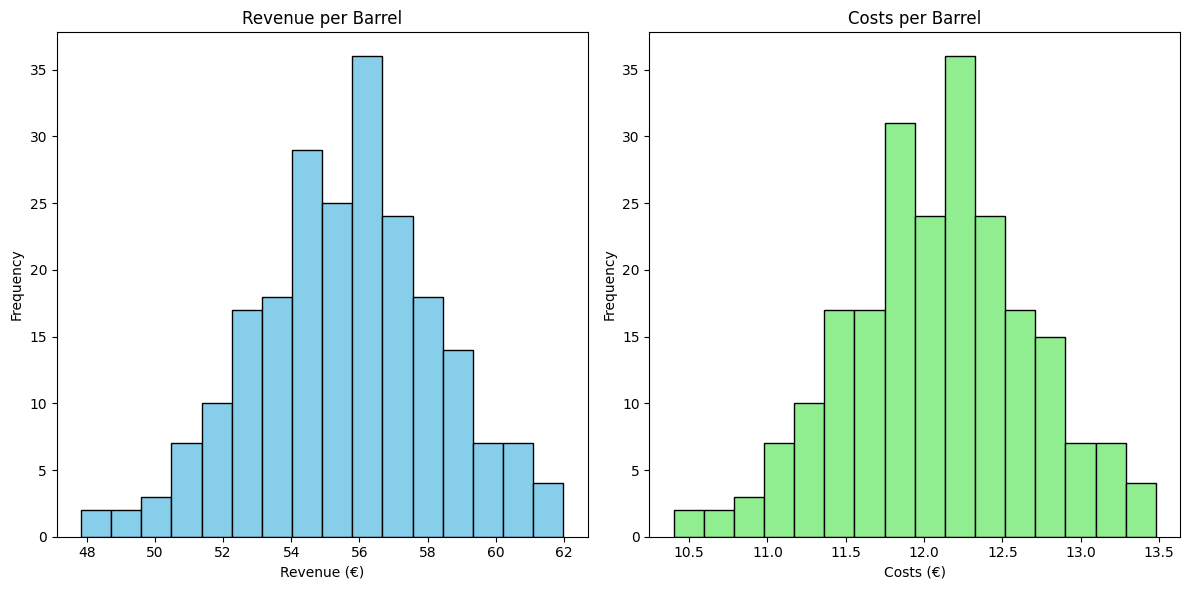

In [29]:
rev_mean, rev_median, rev_range, rev_variance, rev_std, rev_cv, rev_sE, summary_rev = descriptive_stat(df['revenue'], 'revenue')
cost_mean, cost_median, cost_range, cost_variance, cost_std, cost_cv, cost_sE, summary_cost = descriptive_stat(df['costs'], 'costs')
merged_summary = pd.merge(summary_rev, summary_cost)
print(merged_summary)

# Plot histograms for Revenue and Costs per Barrel
plt.figure(figsize=(12, 6))

# Histogram for Revenue
plt.subplot(1, 2, 1)
plt.hist(df['revenue'], bins=16, color='skyblue', edgecolor='black')
plt.title('Revenue per Barrel')
plt.xlabel('Revenue (€)')
plt.ylabel('Frequency')

# Histogram for Costs
plt.subplot(1, 2, 2)
plt.hist(df['costs'], bins=16, color='lightgreen', edgecolor='black')
plt.title('Costs per Barrel')
plt.xlabel('Costs (€)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

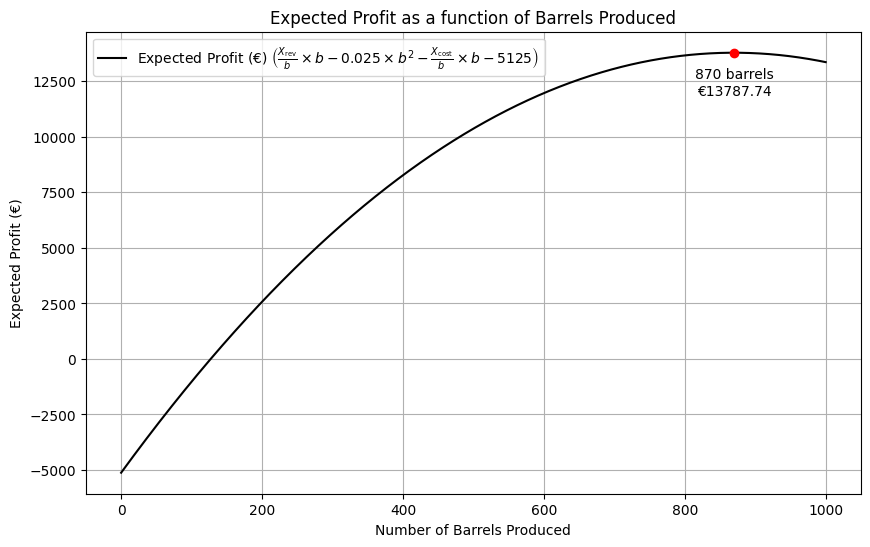

In [30]:
# 𝑒𝑥𝑝𝑒𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑓𝑖𝑡 (€)=𝑋̅𝑟𝑒𝑣/𝑏 ∗𝑏−0.025∗𝑏2 −𝑋̅𝑐𝑜𝑠𝑡/𝑏 ∗𝑏−5125 

# Define the profit function
def expected_profit(b, rev, cost):
    return (rev * b) - (0.025 * b**2) - (cost * b) - 5125

b_values = np.arange(0, 1001)
profit_values = expected_profit(b_values, rev_mean, cost_mean)

max_profit = np.max(profit_values) # Max profit
b_at_max_profit = b_values[np.argmax(profit_values)]  # Number of barrels at max profit

# LaTeX version of the formula
formula = r"$\left(\frac{X_{\text{rev}}}{b} \times b - 0.025 \times b^2 - \frac{X_{\text{cost}}}{b} \times b - 5125\right)$"

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(b_values, profit_values, label=r"Expected Profit (€) " + formula, color='black')
plt.title("Expected Profit as a function of Barrels Produced")
plt.xlabel("Number of Barrels Produced")
plt.ylabel("Expected Profit (€)")
plt.grid(True)
plt.legend()

plt.scatter(b_at_max_profit, max_profit, color='red', zorder=5)
plt.text(b_at_max_profit, max_profit - 1900, f'{b_at_max_profit} barrels\n€{max_profit:.2f}', 
         color='black', ha='center', fontsize=10)

plt.show()

## 2 Additives Guideline

In [31]:
del_mean, del_median, del_range, del_variance, del_std, del_cv, del_sE, del_summary = descriptive_stat(df['delivery_time'], 'delivery_time')

print(del_summary)
print(df['delivery_time'].value_counts(normalize=True) * 100)
N_expired = 15000
growth_rate = 1.65

# Calculate days till expirement and required additives
def expiry(additives=0):
    return(np.log(N_expired) / growth_rate) + (additives / 1.21)

days_till_exp = expiry()
print(f"days_till_exp without additives: {days_till_exp}")

def required_additives(days_till_exp, total_shelf_life):
    days_to_extend =  (total_shelf_life - days_till_exp) 
    return days_to_extend * 1.21

# Needed shelf_life
target_shelf_life = del_mean + 7 # Delivery time + in-store shelf life
print(f"Average delivery days: {del_mean}")
print(f"Needed shelf days: {target_shelf_life}")

print(f"Required additives to reach target: {required_additives(days_till_exp, target_shelf_life)}")
print(f"Required additives to reach target with a day shorter delivery time: {required_additives(days_till_exp, (target_shelf_life-1))}")

print(f"Days to expiry given 1.5 additives: {expiry(1.5)}")
print(f"In-store shelf-life given 1.5 additives {expiry(1.5) - del_mean}")

                     Metric  delivery_time
0                      Mean       3.304933
1                    Median       3.000000
2                     Range       3.000000
3                  Variance       0.597599
4             Std Deviation       0.774784
5  Coefficient of variation      23.443273
6                 Std Error       0.051883
delivery_time
3.0    64.573991
4.0    16.143498
5.0    11.210762
2.0     8.071749
Name: proportion, dtype: Float64
days_till_exp without additives: 5.827760897020817
Average delivery days: 3.304932735426009
Needed shelf days: 10.304932735426009
Required additives to reach target: 5.417377924470282
Required additives to reach target with a day shorter delivery time: 4.207377924470282
Days to expiry given 1.5 additives: 7.06743031850842
In-store shelf-life given 1.5 additives 3.7624975830824114


## Supplemental expiry line graph

<function matplotlib.pyplot.show(close=None, block=None)>

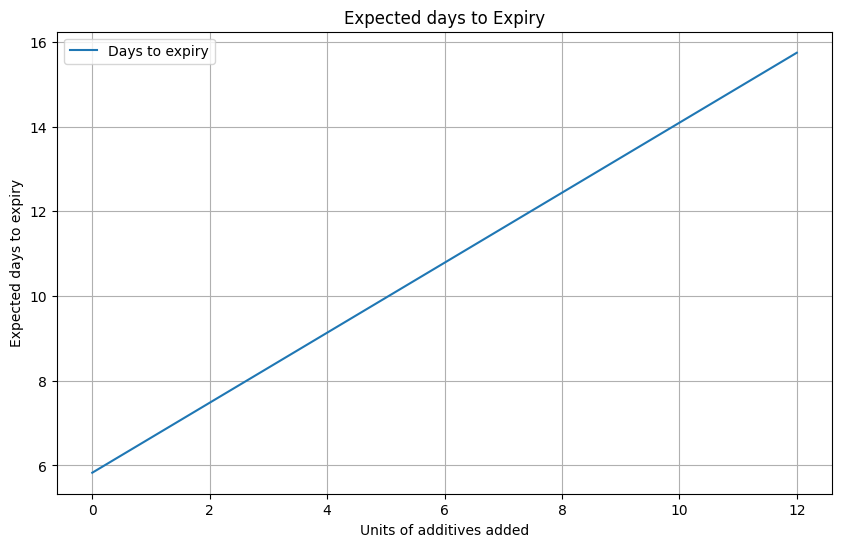

In [32]:
additives_range = np.arange(0, (10*1.21))
expiry_values = expiry(additives_range)

plt.figure(figsize=(10, 6))
plt.plot(additives_range, expiry_values, label="Days to expiry")
plt.title("Expected days to Expiry")
plt.xlabel("Units of additives added")
plt.ylabel("Expected days to expiry")
plt.grid(True)
plt.legend()

plt.show

## 3 Quality check and shelf life

In [33]:
# Calculating the probability of failing the quality check
fail_count = df['quality_check_fail'].sum()
fail_probability = fail_count / sample_size
print(f"Probability of failing quality check: {fail_probability}")

p_value = 1 - binom.cdf(fail_count - 1, sample_size, 0.1)
print(f"Probability of observing {fail_count} or more failures given p = {0.1}: {p_value}")

# Calculating the number of barrels that failed the quality check and have a short shelf life
fail_and_short_shelf_life = len(df[(df['quality_check_fail'] == 1) & (df['shelf_life'] < 8)])

# Conditional probability P(Short Shelf Life | Fails Quality Check)
conditional_probability = fail_and_short_shelf_life / fail_count
print(conditional_probability)

# Conditional probability P(Short Shelf Life | Passes Quality Check)
success_count = df['quality_check_pass'].sum()
success_and_short_shelf_life = len(df[(df['quality_check_pass'] == 1) & (df['shelf_life'] < 8)])
print(success_and_short_shelf_life/success_count)

Probability of failing quality check: 0.15246636771300448
Probability of observing 34.0 or more failures given p = 0.1: 0.008819359794139614
0.7941176470588235
0.005291005291005291


## 4 Shelf life warranty

                     Metric  shelf_life
0                      Mean    9.081353
1                    Median    9.039598
2                     Range    5.421143
3                  Variance    0.928745
4             Std Deviation    0.965882
5  Coefficient of variation   10.635884
6                 Std Error    0.064680


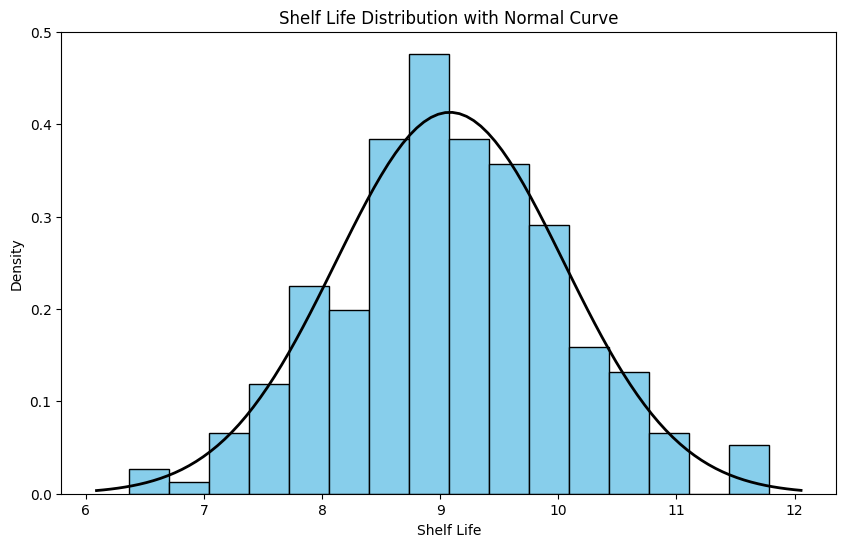

Warranty should cover shelf lives till 10.67008719934045 days
Shelf life of 10 days covers approximately 82.92% of the population.
Shelf life of 11 days covers approximately 97.65% of the population.


In [34]:
sl_mean, sl_median, sl_range, sl_variance, sl_std, sl_cv, sl_sE, summary_sl = descriptive_stat(df['shelf_life'], 'shelf_life')
print(summary_sl)

plt.figure(figsize=(10, 6))
plt.hist(df['shelf_life'], bins=16, color='skyblue', edgecolor='black', density=True)

# Overlay normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, sl_mean, sl_std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Shelf Life Distribution with Normal Curve')
plt.xlabel('Shelf Life')
plt.ylabel('Density')
plt.show()

# Calculate the warranty days required to cover the first 95% of shelf lives
Z = norm.ppf(0.95)
warranty = sl_mean + Z * sl_std 
print(f"Warranty should cover shelf lives till {warranty} days")

# Since the warranty days should probably be a whole number, the % of barrels covered by 10 days and 11 daqys is calculated.
shelf_lives = [10, 11]
for sl in shelf_lives:
    Z = (sl - sl_mean) / sl_std
    percentile = norm.cdf(Z)  # CDF to find the percentile
    print(f"Shelf life of {sl} days covers approximately {percentile * 100:.2f}% of the population.")

## 5 Delivery time increase hypothesis

In [35]:
population_mean = 2.0

t_statistic, p_value = ttest_1samp(df['delivery_time'], popmean=population_mean, alternative = 'greater')

print(f"Calculated t-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

critical_t_value = t.ppf(0.95, sample_size-1)
print(f"Critical t-value {critical_t_value}")

#We reject the null hypothesis because p < 0.05 and critical_t_value < t-statistic

Calculated t-statistic: 25.15
P-value: 0.0000
Critical t-value 1.6517463586794643


## 6 Barrel liters hypothesis

In [36]:
print(df['quality_check_pass'].value_counts())
liters_passed = df[df['quality_check_pass'] == 1]['liters']
liters_failed = df[df['quality_check_fail'] == 1]['liters']

t_stat, p_value = ttest_ind(liters_passed, liters_failed, alternative='two-sided')

critical_t_value = t.ppf(0.95, sample_size-2)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Critical t-value {critical_t_value}")

# We do not reject null hypothesis because p > 0.05 and critical_t_value > t-statistic


quality_check_pass
1.0    189
0.0     34
Name: count, dtype: Int64
T-statistic: 1.0030
P-value: 0.3169
Critical t-value 1.651777679314252


## 7 Confidence in sample data

In [37]:
df = sample_size - 1

# Get the t-value for 95% confidence
alpha = 0.05
t_value = t.ppf(1 - alpha/2, df)

# Calculate the margin of error
margin_of_error = t_value * (sl_std / np.sqrt(sample_size))
print(f"Margin of Error: {margin_of_error:.2f} days")

# Calculate the confidence interval
l_bound = sl_mean - margin_of_error
u_bound = sl_mean + margin_of_error

print(f"The true shelf life is likely to fall between {l_bound:.2f} days and {u_bound:.2f} days.")

percentage_variance = margin_of_error / sl_mean * 100
print(f"Percentage of MoE: {percentage_variance}")


Margin of Error: 0.13 days
The true shelf life is likely to fall between 8.95 days and 9.21 days.
Percentage of MoE: 1.4035997850605015
